# Advanced Portfolio Optimization: The Black-Litterman Model

 ## Motivation

__Problems of Mean-Variance-Optimization (MVO)__

- can lead to __short__ positions and positions __> 1__ (unbounded)
- will certainly lead to __concentrated__ portfolios (unbounded)
- highly dependent on & sensitive to __inputs/assumptions__ (return forecasts) -> GIGO
- small changes in forecasts (returns) lead to __large changes in weights__ (rebalancing costs!)
- __no guarantee__ that MVO-optimized Portfolio performs better than naive-diversified portfolio

__Biggest Issue: Forecasting Returns__

There are various return forecasting models. But, these models:
- lead to conflicting results...
- require assumptions/inputs (GIGO)...
- don´t guarantee accurate forecasts
- can´t be applied to all asset classes (e.g. Cryptocurrencies)

__Alternative Approach__: Why not starting with (average) __Market Expectations__ (implied returns)?

__Reverse Optimization:__

Inputs:

- Return of risk-free Asset
- expected Variances / Covariances
- __market cap weights (efficient)__

Output:

- __Implied Returns__ (market expectation)

__Key Learnings__:
- Black-Litterman (BL) more meaningful/reliable if the entire market is included 
- small forecast changes lead to large changes in weights (be careful)
- BL should be combined with additional bounds/constraints
- opinions should be derived from / verified with other forecasting models

## (Inputs for reverse Optimization)

In [101]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.6f}'.format
import matplotlib.pyplot as plt
import yfinance as yf

start = '2019-09-09'
end = '2024-09-09'
symbol = ['AAPL', 'BA', 'TSLA', 'WMT', 'MSFT', 'JPM', 'DIS', 'GE']
df = yf.download(symbol, start, end ).Close
df

[*********************100%%**********************]  8 of 8 completed


Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-09,53.542500,358.779999,138.830002,44.657848,115.400002,137.520004,15.452667,38.776669
2019-09-10,54.174999,369.489990,135.789993,45.554993,116.870003,136.080002,15.702667,38.683334
2019-09-11,55.897499,382.940002,136.190002,46.651501,117.190002,136.119995,16.473333,38.673332
2019-09-12,55.772499,375.630005,137.500000,46.153088,117.910004,137.520004,16.391333,38.973331
2019-09-13,54.687500,379.760010,138.020004,46.551819,120.230003,137.320007,16.346666,39.143333
...,...,...,...,...,...,...,...,...
2024-08-30,229.000000,173.740005,90.379997,174.619995,224.800003,417.140015,214.110001,77.230003
2024-09-03,222.770004,161.020004,89.129997,164.210007,220.300003,409.440002,210.600006,77.169998
2024-09-04,220.850006,163.220001,89.250000,166.360001,219.330002,408.899994,219.410004,77.239998


__Return of Risk-free Assets:__

In [104]:
rf = 0.03

__Market Cap Weights__, as of 2022-06-30: 

In [107]:
weights= {'AAPL': 0.3758452265955565,
          'BA': 0.01379913198459885,
          'DIS': 0.029242799417694997,
          'GE': 0.011873988109005319,
          'JPM': 0.05616250119046,
          'MSFT': 0.32652616971197673,
          'TSLA': 0.1298723826886709,
          'WMT': 0.0566778003020367}
weights

{'AAPL': 0.3758452265955565,
 'BA': 0.01379913198459885,
 'DIS': 0.029242799417694997,
 'GE': 0.011873988109005319,
 'JPM': 0.05616250119046,
 'MSFT': 0.32652616971197673,
 'TSLA': 0.1298723826886709,
 'WMT': 0.0566778003020367}

In [109]:
weights = pd.Series(weights)
weights

AAPL   0.375845
BA     0.013799
DIS    0.029243
GE     0.011874
JPM    0.056163
MSFT   0.326526
TSLA   0.129872
WMT    0.056678
dtype: float64

In [111]:
df

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-09,53.542500,358.779999,138.830002,44.657848,115.400002,137.520004,15.452667,38.776669
2019-09-10,54.174999,369.489990,135.789993,45.554993,116.870003,136.080002,15.702667,38.683334
2019-09-11,55.897499,382.940002,136.190002,46.651501,117.190002,136.119995,16.473333,38.673332
2019-09-12,55.772499,375.630005,137.500000,46.153088,117.910004,137.520004,16.391333,38.973331
2019-09-13,54.687500,379.760010,138.020004,46.551819,120.230003,137.320007,16.346666,39.143333
...,...,...,...,...,...,...,...,...
2024-08-30,229.000000,173.740005,90.379997,174.619995,224.800003,417.140015,214.110001,77.230003
2024-09-03,222.770004,161.020004,89.129997,164.210007,220.300003,409.440002,210.600006,77.169998
2024-09-04,220.850006,163.220001,89.250000,166.360001,219.330002,408.899994,219.410004,77.239998


In [113]:
returns = df.pct_change()
returns

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-10,0.011813,0.029851,-0.021897,0.020089,0.012738,-0.010471,0.016178,-0.002407
2019-09-11,0.031795,0.036402,0.002946,0.024070,0.002738,0.000294,0.049079,-0.000259
2019-09-12,-0.002236,-0.019089,0.009619,-0.010684,0.006144,0.010285,-0.004978,0.007757
2019-09-13,-0.019454,0.010995,0.003782,0.008639,0.019676,-0.001454,-0.002725,0.004362
...,...,...,...,...,...,...,...,...
2024-08-30,-0.003438,0.008592,0.006347,0.005991,0.011656,0.009731,0.037958,0.010599
2024-09-03,-0.027205,-0.073213,-0.013830,-0.059615,-0.020018,-0.018459,-0.016393,-0.000777
2024-09-04,-0.008619,0.013663,0.001346,0.013093,-0.004403,-0.001319,0.041833,0.000907


__Covariance Matrix:__

In [116]:
cov_matrix = returns.cov() * 252
cov_matrix

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Ticker,,,,,,,,
AAPL,0.100524,0.065758,0.047655,0.046143,0.043029,0.071839,0.102376,0.026092
BA,0.065758,0.259805,0.088111,0.124452,0.095406,0.057007,0.107528,0.017760
DIS,0.047655,0.088111,0.115289,0.065014,0.061581,0.049045,0.071607,0.018183
GE,0.046143,0.124452,0.065014,0.157411,0.079695,0.043903,0.060724,0.015356
JPM,0.043029,0.095406,0.061581,0.079695,0.102221,0.041689,0.056110,0.017977
MSFT,0.071839,0.057007,0.049045,0.043903,0.041689,0.091758,0.089836,0.025876
TSLA,0.102376,0.107528,0.071607,0.060724,0.056110,0.089836,0.433666,0.021681
WMT,0.026092,0.017760,0.018183,0.015356,0.017977,0.025876,0.021681,0.049700


## Black-Litterman Step 1: Reverse Optimization

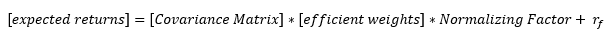

__Normalizing Factor:__

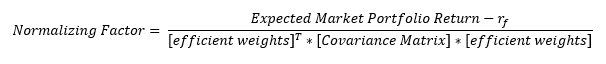

__Expected Return of Market Portfolio__ (rough guess)

In [124]:
rm = 0.1
rm

0.1

In [126]:
nf = (rm - rf) / (weights.T.dot(cov_matrix).dot(weights))
nf

0.8790141009348219

In [128]:
impl_ret = cov_matrix.dot(weights) * nf + rf
impl_ret

Ticker
AAPL   0.101445
BA     0.092672
DIS    0.076652
GE     0.074301
JPM    0.072101
MSFT   0.096084
TSLA   0.146743
WMT    0.052729
dtype: float64

-> Implied/expected returns. -> Market Cap weighted Porfolio == Optimal Portfolio 

__Cross Check (MVO Optimization)__

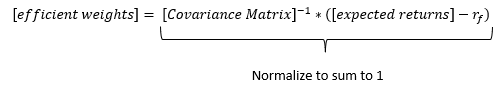

In [133]:
weights

AAPL   0.375845
BA     0.013799
DIS    0.029243
GE     0.011874
JPM    0.056163
MSFT   0.326526
TSLA   0.129872
WMT    0.056678
dtype: float64

In [135]:
cov_matrix_inv = pd.DataFrame(np.linalg.pinv(cov_matrix.values), cov_matrix.columns, cov_matrix.index)
cov_matrix_inv

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Ticker,,,,,,,,
AAPL,25.622801,-1.323390,-0.489411,-0.344630,-0.967695,-15.327886,-2.119254,-3.438318
BA,-1.323390,7.498646,-1.791533,-3.423874,-2.735526,0.590980,-0.573138,0.660318
DIS,-0.489411,-1.791533,15.192073,-1.217607,-4.601380,-3.298526,-0.464589,-0.700363
GE,-0.344630,-3.423874,-1.217607,12.599721,-5.627301,-0.727715,0.232438,0.269933
JPM,-0.967695,-2.735526,-4.601380,-5.627301,20.733195,-1.430438,0.164137,-1.918709
MSFT,-15.327886,0.590980,-3.298526,-0.727715,-1.430438,27.632569,-1.217140,-4.071011
TSLA,-2.119254,-0.573138,-0.464589,0.232438,0.164137,-1.217140,3.193561,0.596723
WMT,-3.438318,0.660318,-0.700363,0.269933,-1.918709,-4.071011,0.596723,24.415820


In [137]:
w = cov_matrix_inv.dot(impl_ret - rf)
w

Ticker
AAPL   0.330373
BA     0.012130
DIS    0.025705
GE     0.010437
JPM    0.049368
MSFT   0.287021
TSLA   0.114160
WMT    0.049821
dtype: float64

In [139]:
optimal_weights = (w/w.sum())
optimal_weights

Ticker
AAPL   0.375845
BA     0.013799
DIS    0.029243
GE     0.011874
JPM    0.056163
MSFT   0.326526
TSLA   0.129872
WMT    0.056678
dtype: float64

In [141]:
weights

AAPL   0.375845
BA     0.013799
DIS    0.029243
GE     0.011874
JPM    0.056163
MSFT   0.326526
TSLA   0.129872
WMT    0.056678
dtype: float64

## Black-Litterman Step 2: Incorporating Investor Opinions 

In [145]:
impl_ret

Ticker
AAPL   0.101445
BA     0.092672
DIS    0.076652
GE     0.074301
JPM    0.072101
MSFT   0.096084
TSLA   0.146743
WMT    0.052729
dtype: float64

__Two options:__

1. Agree with implied returns / market expectations? <br>
 - Invest in the Market Portfolio (Market Cap weighted)

2. Know better than the market?
- Add (subjective) opinions by adjusting implied returns 

In [153]:
impl_ret

Ticker
AAPL   0.101445
BA     0.092672
DIS    0.076652
GE     0.074301
JPM    0.072101
MSFT   0.096084
TSLA   0.146743
WMT    0.052729
dtype: float64

In [155]:
opinion = pd.Series(data = [-0.01, -0.01, +0.01, 0, 0, -0.01, -0.01, +0.01], index = impl_ret.index)
opinion

Ticker
AAPL   -0.010000
BA     -0.010000
DIS     0.010000
GE      0.000000
JPM     0.000000
MSFT   -0.010000
TSLA   -0.010000
WMT     0.010000
dtype: float64

In [157]:
forecast = impl_ret + opinion
forecast

Ticker
AAPL   0.091445
BA     0.082672
DIS    0.086652
GE     0.074301
JPM    0.072101
MSFT   0.086084
TSLA   0.136743
WMT    0.062729
dtype: float64

In [159]:
w = cov_matrix_inv.dot(forecast - rf)
w

Ticker
AAPL    0.222573
BA     -0.061113
DIS     0.231063
GE      0.043598
JPM     0.033862
MSFT    0.096541
TSLA    0.122641
WMT     0.349498
dtype: float64

In [161]:
optimal_weights = (w/w.sum()) 
optimal_weights

Ticker
AAPL    0.214288
BA     -0.058839
DIS     0.222462
GE      0.041976
JPM     0.032602
MSFT    0.092947
TSLA    0.118076
WMT     0.336489
dtype: float64

In [163]:
weights

AAPL   0.375845
BA     0.013799
DIS    0.029243
GE     0.011874
JPM    0.056163
MSFT   0.326526
TSLA   0.129872
WMT    0.056678
dtype: float64